<a href="https://colab.research.google.com/github/Alla-ud-din/Classes-Q3-Q4/blob/langgraph/LangGraph/AGENTIC_PROJECTS/01_human_interactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project 01: User-Chat-Interactions**

---

### **Objective:**
Make your chat-agent developed in 00_chat_agent smarter by allowing it to:
1. Get help from a human assistant when needed.
2. Pause and ask the user for extra information if something is unclear.
3. Personalize its answers using long-term memory.
4. Offloading conversation to Human

**Note:** This project builds on the skills learned in Project 00 and prepares you for advanced Agentic AI features like dynamic workflows and user personalization.

---

### **Requirements:**

1. **Human Assistant Interrupts (Static Interrupts):**
   - Add a feature where your chatbot can **pause** and connect to a human assistant if needed.
   - This can be a **static interrupt**—you decide when the chatbot needs help from a human.
   - Example: If the chatbot can’t answer a question or doesn’t have enough information, it stops and sends the question to a human for assistance.

**Reference Material:**
- [Static Breakpoints](https://github.com/panaversity/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-3/2_breakpoints.ipynb)

2. **Ask the User for More Information (Dynamic Interrupts):**
   - Make the chatbot smart enough to **pause its workflow** and ask the user for more information when it’s confused.
   - Steps:
     - Add a **decision step** after each user message.
     - If the chatbot detects a question or needs more details, it pauses and asks the user to clarify.
     - The user can:
       - **Answer the question** to help the chatbot.
       - **Skip the question** and let the chatbot guess the best answer.

**Reference Material:**
- [Dynamic Breakpoints](https://github.com/panaversity/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-3/4_dynamic_breakpoints.ipynb)
- [Editing State](https://github.com/panaversity/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-3/3_edit_state_human_feedback.ipynb)

3. **(Optional) Personalize Using Long-Term Memory:**
   - Use a memory system to **save important details** about the user.
   - Examples of what to remember:
     - Preferences (e.g., favorite subjects, preferred clothing styles).
     - Recurring needs (e.g., study schedules, favorite recipes).
   - Use this memory to give **better and more personal answers** over time.

**Tools:** Use **LangGraph Memory Store** to save and retrieve user data.

**Reference Material:**
- [Concept](https://langchain-ai.github.io/langgraph/concepts/memory/#long-term-memory)
- [Memory Template](https://github.com/langchain-ai/memory-template)

*Note:* This is an optional step. Focus on completing the first two requirements before attempting long-term memory integration if you feel confident.

---

### **Deliverables:**
- A working chatbot prototype with:
  1. Human assistant interrupts.
  2. Dynamic user clarifications.
  3. Long-term memory for personalization (Optional).

---

## **Submission Form**

Submit your projects here:  
[**Project Submission Form**](https://forms.gle/yB6X4TzE2dCVThCj8)

---

### **Example Scenarios:**

1. **Human Assistant Interrupt:**
   - User asks: *"Can you help with tax calculations?"*
   - Chatbot: *"Let me connect you to a human assistant for this question."*
   
2. **Dynamic Interrupt:**
   - User asks: *"Plan a study schedule for me."*
   - Chatbot: *"What is your next exam date? Should I include break times?"*

3. **Personalized Memory (Optional):**
   - User: *"What should I study today?"*
   - Chatbot: *"Last time, you said your math exam is next week. Let’s focus on trigonometry today."*

---

### **Outcomes:**
By completing this project, you will:
1. Learn how to connect a chatbot with a human assistant.
2. Understand how to make chatbots pause and ask for clarifications when needed.
3. Use long-term memory to personalize chatbot responses.

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=GEMINI_API_KEY
)

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=2)
# llm.invoke("greet me")
# tavily_search.invoke("What's a 'node' in LangGraph?")

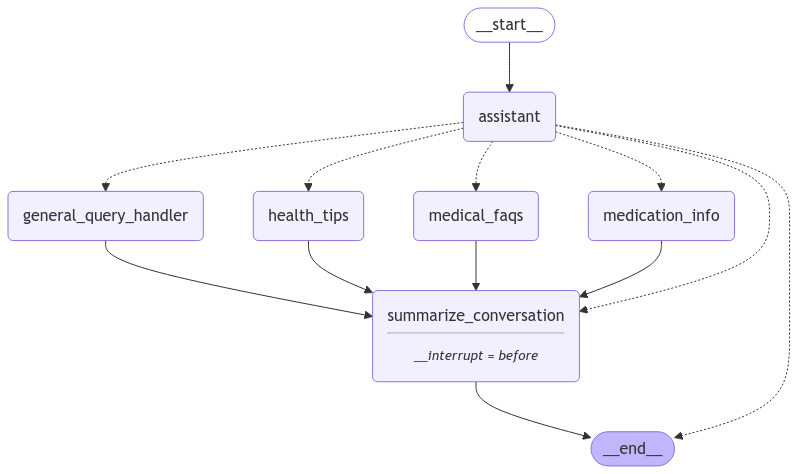

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage, SystemMessage, RemoveMessage
from langgraph.errors import NodeInterrupt
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver

# Define the State class to manage the state transitions
class State(TypedDict):
    user_query: Annotated[list[AnyMessage], add_messages]  # Stores user input messages
    response: Annotated[list[AnyMessage], add_messages]  # Stores assistant responses
    summary: str  # Stores a summary of the conversation

# Initialize a state graph builder
graph_builder = StateGraph(State)

# Define tool: Health Tips
def health_tips(state: State) -> State:
    """Provide health tips using Tavily Search."""
    user_query = state['user_query'][-1].content  # Extract user query
    tavily_response = tavily_search.invoke(user_query)  # Call Tavily Search API
    print("Tavily_response: ", tavily_response)
    formatted_response = "\n\n".join(
            f"- (Source: {item.get('url', 'No URL')}) {item.get('content', 'No content')}\n  "
            for item in tavily_response
        )
    print("Here are some health tips: \n")
    return {"response": [AIMessage(content=formatted_response)]}  # Return the response

# Define tool: Medical FAQs
def medical_faqs(state: State) -> State:
    """Provide medical FAQs for a given condition using Tavily Search."""
    user_query = state['user_query'][-1].content  # Extract user query
    query = f"Medical FAQs about: {user_query}"
    tavily_response = tavily_search.invoke(query)  # Call Tavily Search API
    formatted_response = "\n\n".join(
            f"- (Source: {item.get('url', 'No URL')}) {item.get('content', 'No content')}\n  "
            for item in tavily_response
        )
    print("Here are some FAQs: \n")
    return {"response": [AIMessage(content=formatted_response)]}  # Return the response

# Define tool: Medication Info
def medication_info(state: State) -> State:
    """Provide information about medications."""
    user_query = state['user_query'][-1].content  # Extract user query
    query = f"Medication information for: {user_query}"
    tavily_response = tavily_search.invoke(query)  # Call Tavily Search API
    formatted_response = "\n\n".join(
            f"- (Source: {item.get('url', 'No URL')}) {item.get('content', 'No content')}\n  "
            for item in tavily_response
        )
    print("Here is some information about the medication:\n")
    return {"response": [AIMessage(content=formatted_response)]}  # Return the response

# Define tool: General Query Handler
def general_query_handler(state: State) -> State:
    """Handle general queries unrelated to medical topics."""
    user_query = state['user_query'][-1].content  # Extract user query
    response = (f"It seems like your query is unrelated to medical topics. "
                f"Here's a general response to '{user_query}': I'm here to help, "
                "but I specialize in health-related queries. Could you clarify or ask something health-related?")
    return {"response": [response]}  # Return the response

# List of tools
tools = [health_tips, medical_faqs, medication_info, general_query_handler]

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# Define a system message to guide the assistant
sys_msg = SystemMessage(content="You are a helpful assistant tasked with helping users with their medical queries."
                        "Return tool call if user's query is related to any tool mentioned."
                        "If you need more details to decide reply 'Can you clarify?'")

# Define the assistant node
def assistant(state: State) -> State:
    """Generate a response from the assistant using the LLM and tools."""
    response = llm_with_tools.invoke([sys_msg] + state["user_query"])  # Get response from the LLM
    print("Response from llm: ", response)
    if "Can you clarify?" in response.content:
        raise NodeInterrupt(f"Received input is not clear: {state['user_query']}")
    return {"response": [response]}  # Return the response

# Define tool calling logic
def tool_calling(state: State):
    """Determine the next tool to call based on model responses."""
    try:
        if state['response'] and hasattr(state['response'][-1], 'tool_calls') and len(state['response'][-1].tool_calls) > 0:
            tool_name = state['response'][-1].tool_calls[-1].get("name", None)  # Extract tool name
            if tool_name:
                return tool_name  # Call the specific tool
        return "summarize_conversation"  # Transition to summarization if no tool is specified
    except Exception as e:
        print(f"[ERROR in tool_calling]: {e}")
        return "summarize_conversation"  # Default to summarization on error

# Define the summarize conversation logic
def summarize_conversation(state: State) -> State:
    """Summarize the conversation so far."""
    # Get the existing summary (if any)
    summary = state.get("summary", "")

    # Create the summarization prompt
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add the summarization prompt to the history
    messages = state["user_query"] + state["response"] + [HumanMessage(content=summary_message)]

    # Filter valid messages (non-empty content)
    valid_messages = [
        message for message in messages
        if hasattr(message, 'content') and message.content  # Ensure 'content' exists and is not empty
    ]

    # Get the response from the LLM
    response = llm.invoke(valid_messages)

    # Create RemoveMessage objects for all but the two most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["user_query"][:-1] + state["response"][:-1]]

    # Return the updated state
    return {
        "summary": str(response.content),  # Update the summary
        "response": [state["response"][-1]],  # Keep only the summarization response
    }

# Initialize the state graph builder
builder: StateGraph = StateGraph(State)

# Define nodes in the graph
builder.add_node("assistant", assistant)
builder.add_node("health_tips", health_tips)
builder.add_node("medical_faqs", medical_faqs)
builder.add_node("medication_info", medication_info)
builder.add_node("general_query_handler", general_query_handler)
builder.add_node("summarize_conversation", summarize_conversation)

# Define edges in the graph
builder.add_edge(START, "assistant")  # Start with the assistant node
builder.add_conditional_edges("assistant", tool_calling)  # Add conditional edges for tool calling

# Tools transition to summarize_conversation
builder.add_edge("health_tips", "summarize_conversation")
builder.add_edge("medical_faqs", "summarize_conversation")
builder.add_edge("medication_info", "summarize_conversation")
builder.add_edge("general_query_handler", "summarize_conversation")

# Summarize conversation transitions to END
builder.add_edge("summarize_conversation", END)

# Initialize memory to save conversation
memory: MemorySaver = MemorySaver()

# Compile the state graph
graph: CompiledStateGraph = builder.compile(interrupt_before = ["summarize_conversation"], checkpointer=memory)

# Visualize the graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
# Specify a thread configuration
config = {"configurable": {"thread_id": "1"}}

In [ ]:
# # Main interaction loop

exit = True
while exit:
    user_input = input("Welcome to HealthHub! How can I assist you today? (type 'quit', 'exit', 'q' to exit): ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye! Stay healthy and take care!")
        break


    for result in graph.stream({"user_query": user_input}, config, stream_mode="updates"):
        print("Result:", result)
        if "__interrupt__" in result and result["__interrupt__"] and "Received input is not clear" in result["__interrupt__"][-1].value: # Check if '__interrupt__' key exists and is not empty
            user_input_clear = input("Kindly explain your query? (type 'quit', 'exit', 'q' to exit): ")
            if user_input_clear.lower() in ["quit", "exit", "q"]:
                print("Goodbye! Stay healthy and take care!")
                exit = False
                break
            graph.update_state(config, {"user_query": user_input + user_input_clear})
            for result in graph.stream(None, config, stream_mode="updates"):
                print("Internal Result:", result)
        if "__interrupt__" in result:
            while True:
                # Get user feedback
                user_approval = input("Are you satisfied with the response? (yes/no): ")
                # Check approval
                if user_approval.lower() == "yes":
                    # If approved, continue the graph execution
                    for result in graph.stream(None, config, stream_mode="updates"):
                        print("Result in second interrupt:", result)
                    break

                elif user_approval.lower() == "no":
                    user_input_detail = input("Kinly provide more details? (type 'quit', 'exit', 'q' to exit): ")
                    if user_input_detail.lower() in ["quit", "exit", "q"]:
                        print("Goodbye! Stay healthy and take care!")
                        exit = False
                        break
                    # Conditionally concatenate user_input_clear if it exists
                    if user_input_clear:
                        user_input_detail = f"{user_input_clear} {user_input_detail}"
                    for result in graph.stream({"user_query": user_input + user_input_detail }, config, stream_mode="updates"):
                        print("Result in second interrupt:", result)

                else:
                    print("Invalid input. Please enter 'yes' or 'no'.")





In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'user_query': [HumanMessage(content='What can I do about pain?', additional_kwargs={}, response_metadata={}, id='542c049f-bab3-422e-a145-ab74f5675626'), HumanMessage(content='What can I do about pain in my head?', additional_kwargs={}, response_metadata={}, id='cb9c360f-ee51-4a02-85da-f0a59bcfdb32'), HumanMessage(content='What are the best practices for staying healthy during flu season?', additional_kwargs={}, response_metadata={}, id='f268fcf6-8278-4d05-875d-2eb2f5fe1682'), HumanMessage(content='What can I do about pain?', additional_kwargs={}, response_metadata={}, id='9900966b-c71b-44d4-92b7-0dfa9acda030'), HumanMessage(content='Can you provide FAQs about hypertension?', additional_kwargs={}, response_metadata={}, id='706978e5-13b4-49fa-ab27-bcb299ae2acf'), HumanMessage(content='Can you provide FAQs about hypertension?', additional_kwargs={}, response_metadata={}, id='4a099be3-2553-47db-be52-62a0adbbcacb'), HumanMessage(content='Can you provide FAQs about hype

In [ ]:
snapshot.next

('summarize_conversation',)

In [ ]:
graph.update_state(config,{"user_query": "What are the best practices for staying healthy during flu season?"})
for result1 in graph.stream(None, config, stream_mode="updates"):
    print("Inrernal Result: ", result1)

Response from llm:  content='' additional_kwargs={'function_call': {'name': 'health_tips', 'arguments': '{"state": "unknown"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-e6307a75-3bb8-425e-81ed-95f5951e740e-0' tool_calls=[{'name': 'health_tips', 'args': {'state': 'unknown'}, 'id': '3b4a2c11-85c8-4be3-a972-f62f5c27cad7', 'type': 'tool_call'}] usage_metadata={'input_tokens': 525, 'output_tokens': 5, 'total_tokens': 530, 'input_token_details': {'cache_read': 0}}
Inrernal Result:  {'assistant': {'response': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'health_tips', 'arguments': '{"state": "unknown"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e6307a75-3bb8-425e-81ed-95f5951e740e-0', tool_calls=[{'name': 'health_tips', 'args': {'state': 'unknown'}, 'id': '3b4a2c11-85c8-4be3-a972

In [ ]:
snapshot.values['response'][-1].content

"[{'url': 'https://www.goodrx.com/metformin/metformin-side-effects', 'content': 'Common metformin side effects include diarrhea, nausea and vomiting, and fatigue. Weight loss and low B12 levels may also occur. Usually, metformin side effects are temporary and can be managed at home. However serious risks, such as very low blood glucose (hypoglycemia) and lactic acidosis, are possible.'}, {'url': 'https://www.drugs.com/sfx/metformin-side-effects.html', 'content': 'Adverse events in the pediatric population appear to be similar in nature and severity to that published in adults.[Ref]\\nMetabolic\\nCommon (1% to 10%): Hypoglycemia\\nVery rare (less than 0.01%): Lactic acidosis[Ref]\\nGastrointestinal\\nVery common (10% or more): Diarrhea (53.2%), nausea/vomiting (25.5%), flatulence (12.1%)\\nCommon (1% to 10%): Indigestion, abdominal discomfort, abnormal stools, dyspepsia, loss of appetite[Ref]\\nHematologic\\nVery rare (less than 0.01%): Subnormal vitamin B12 levels[Ref]\\nOther\\nCommon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
